## Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

## Create Dataframe for Input and Output

In [3]:
data_dir="PetImages"

In [4]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages\Cat\0.jpg 0


In [5]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0  PetImages\Dog\11574.jpg      1
1   PetImages\Cat\3256.jpg      0
2   PetImages\Cat\6562.jpg      0
3  PetImages\Dog\11178.jpg      1
4   PetImages\Cat\9786.jpg      0

In [6]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages\Dog\Thumbs.db
PetImages\Cat\Thumbs.db


In [7]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages\\Dog\\11702.jpg',
 'PetImages\\Cat\\666.jpg',
 'PetImages\\Dog\\Thumbs.db',
 'PetImages\\Cat\\Thumbs.db']

In [8]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

25002

## Exploratory Data Analysis

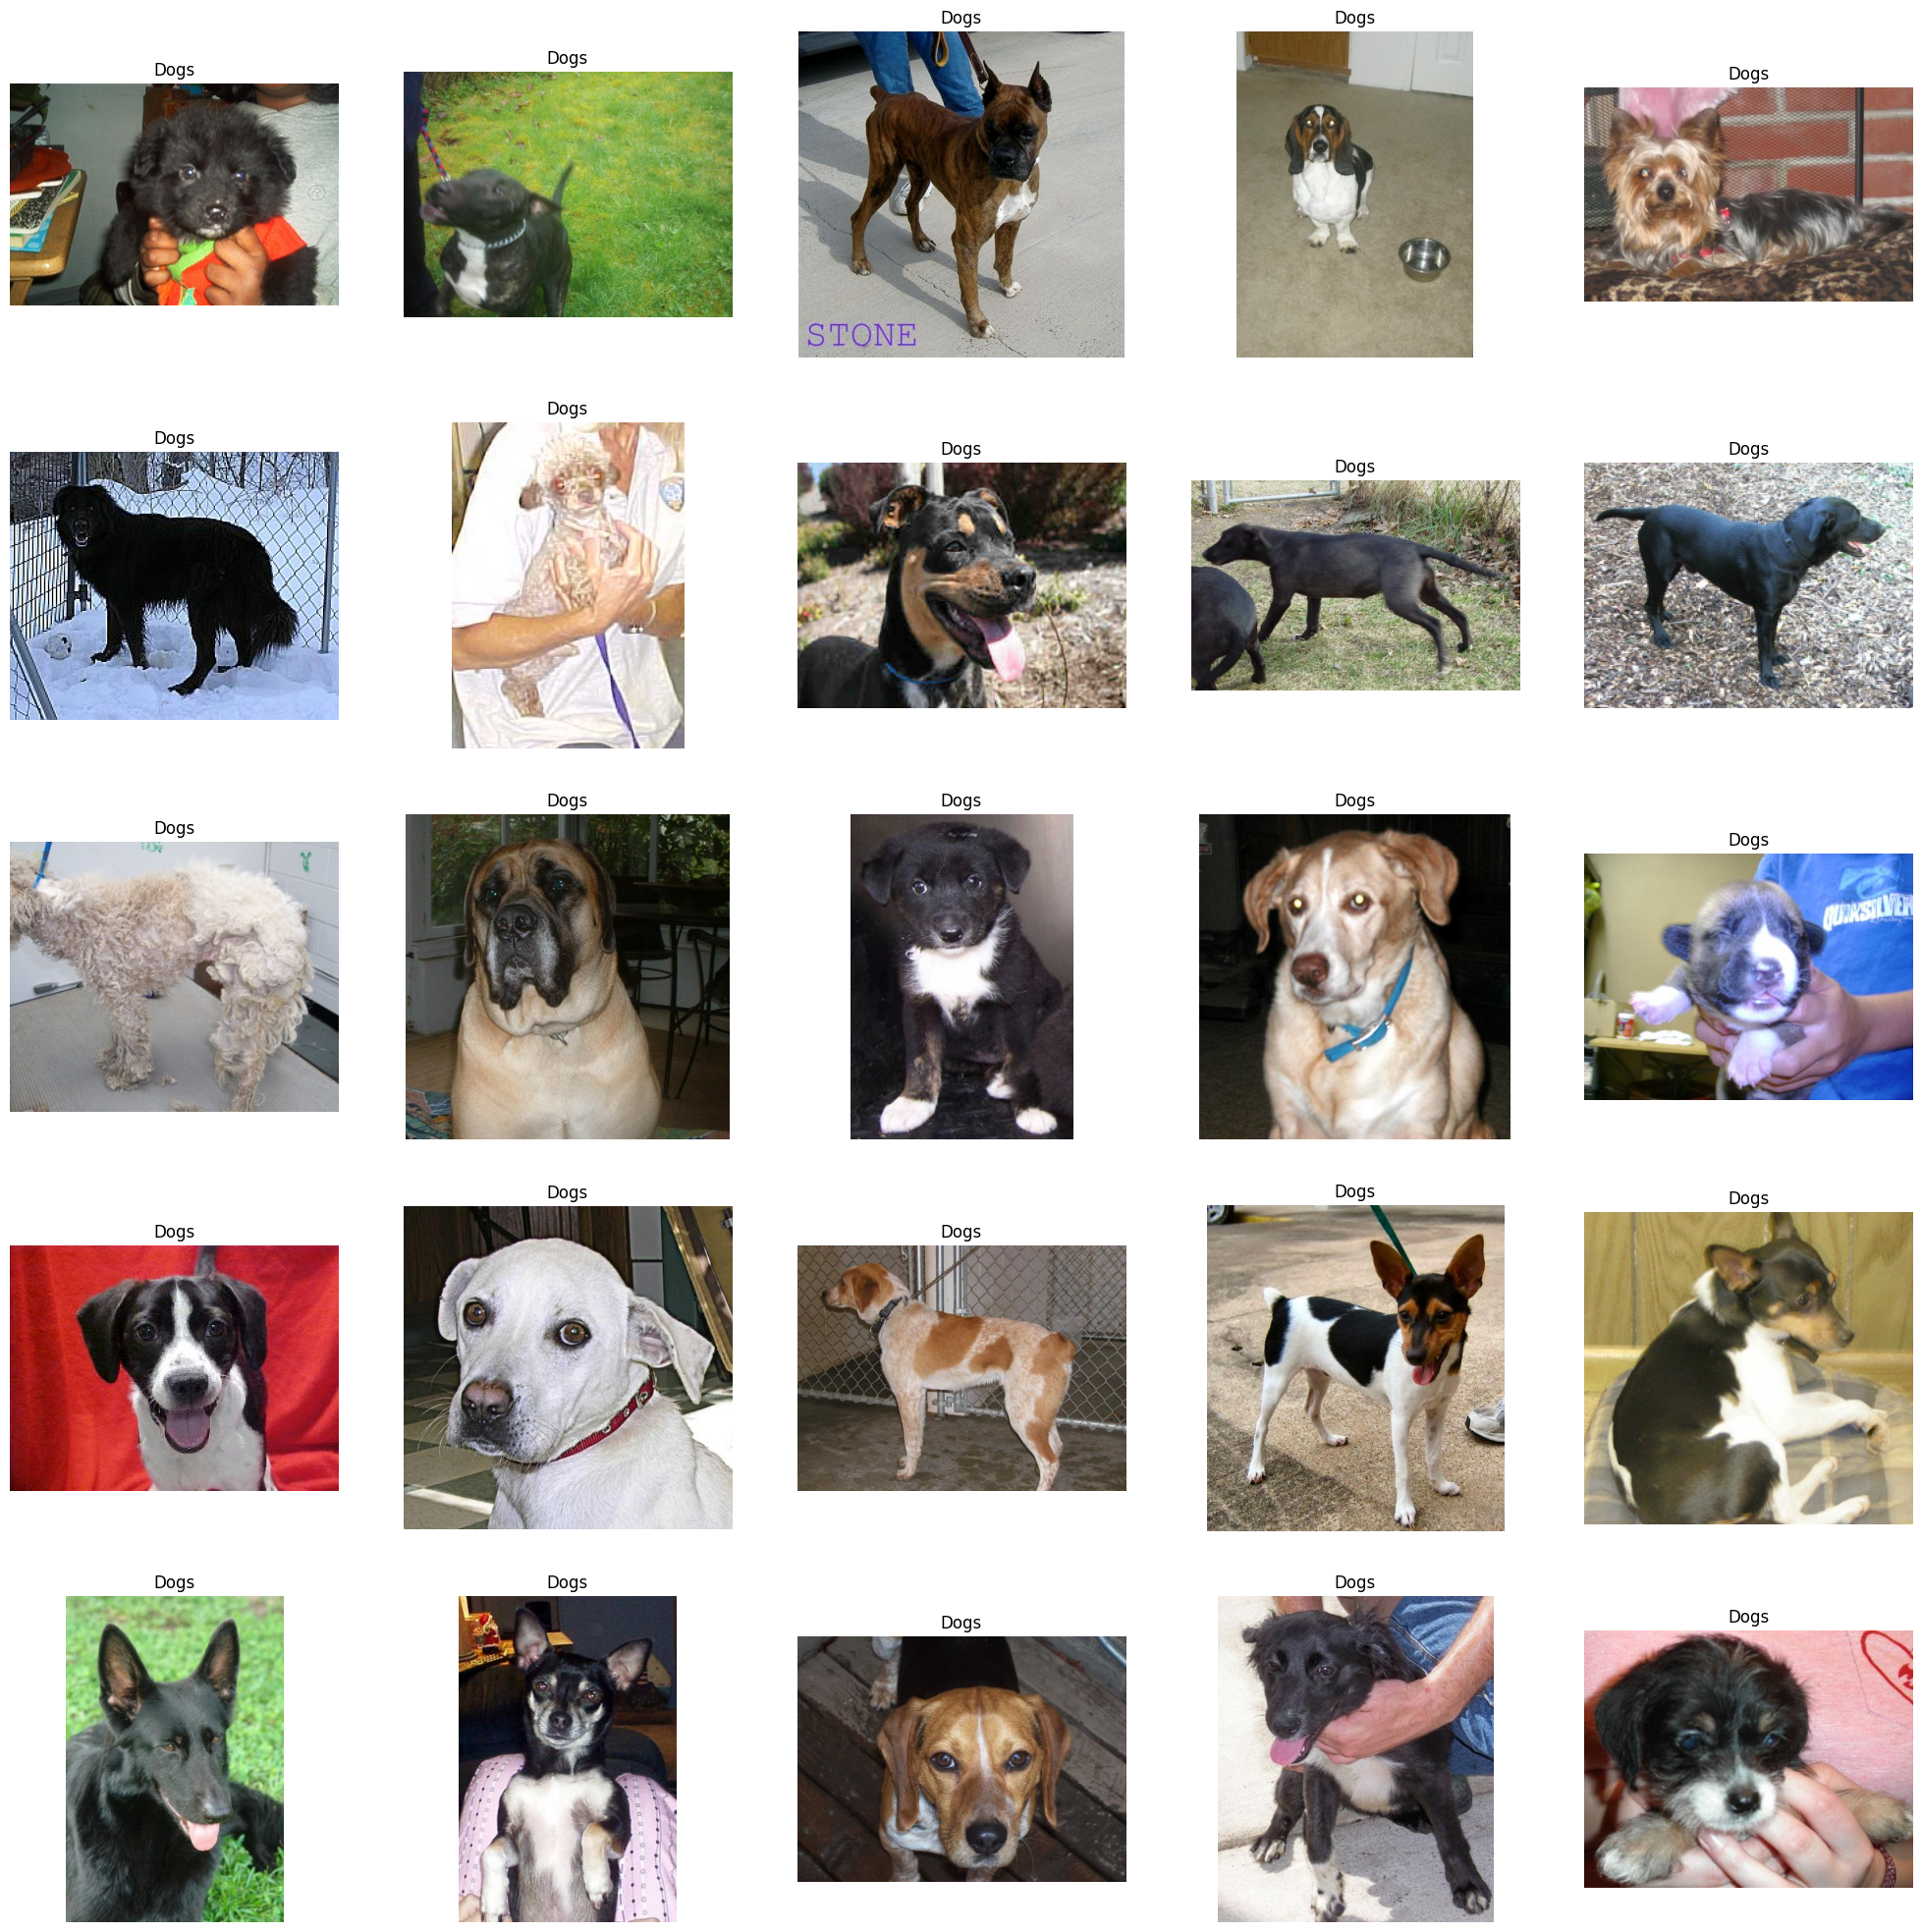

In [9]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

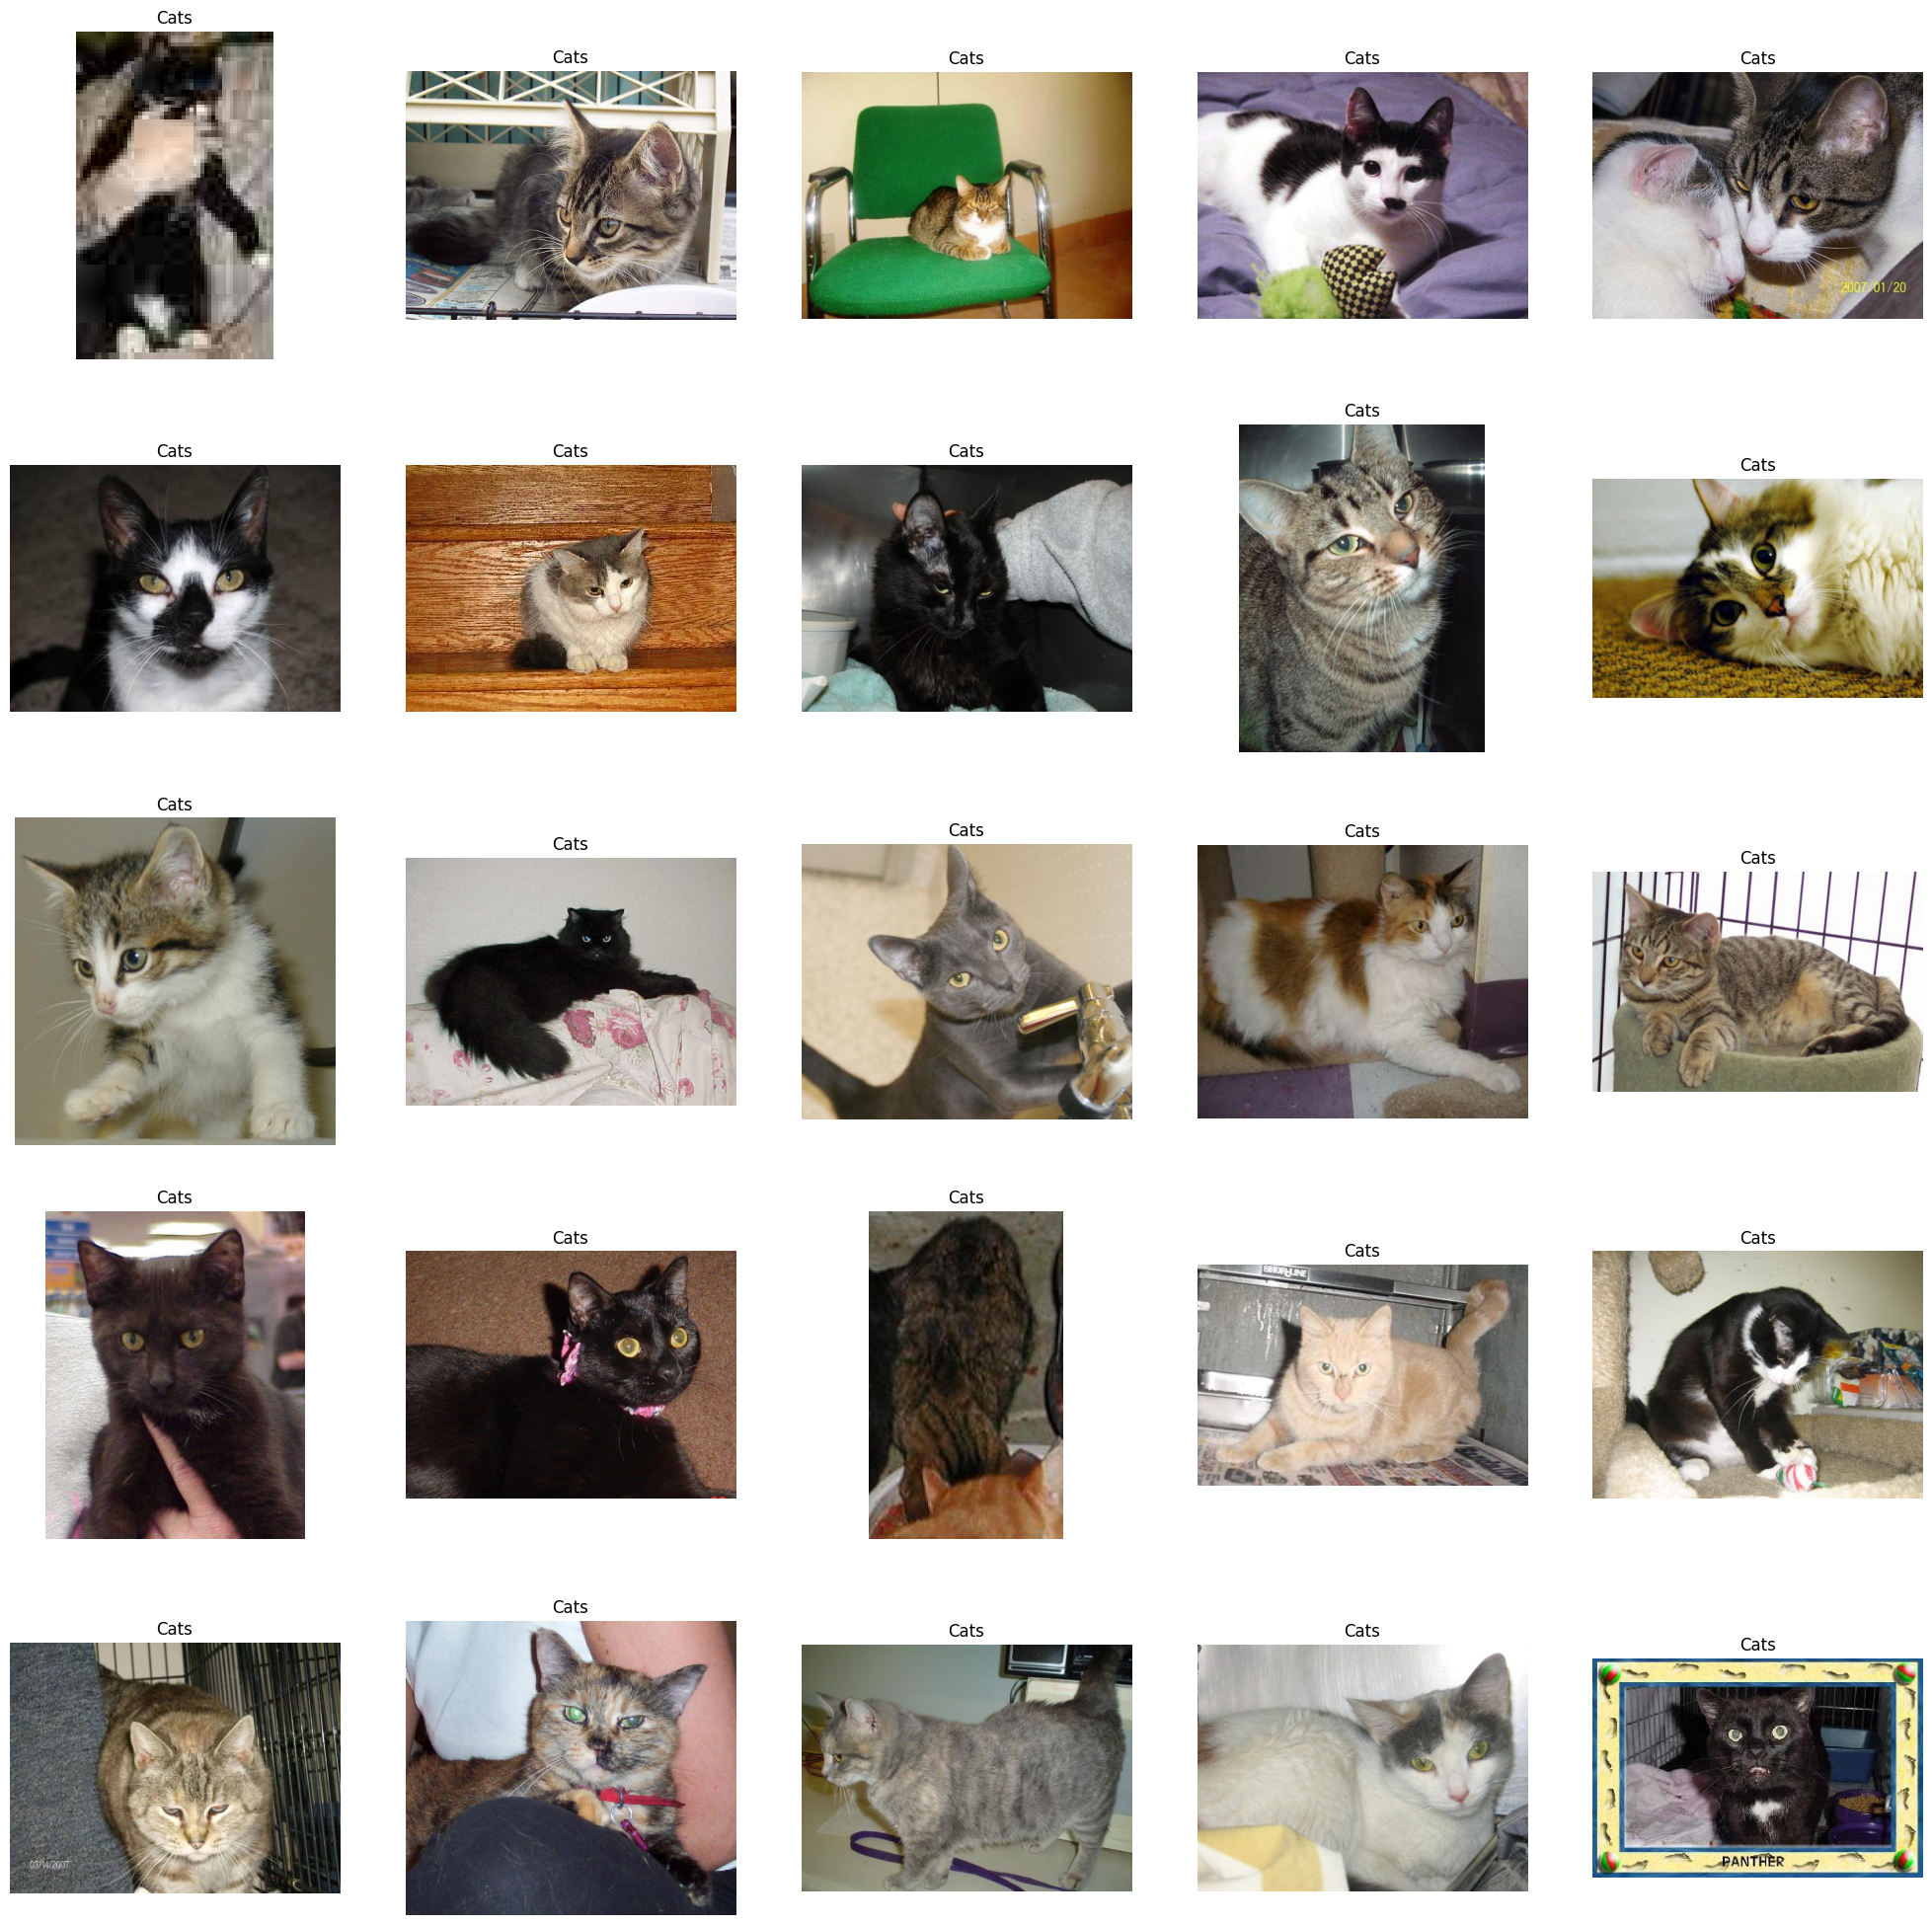

In [10]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

<Axes: ylabel='count'>

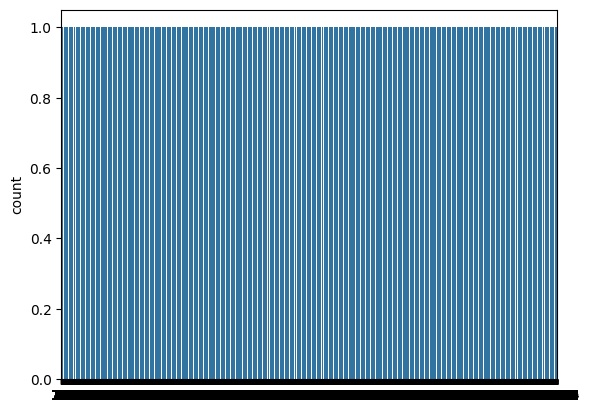

In [11]:
import seaborn as sns
sns.countplot(df['label'])

In [20]:
df["label"]

0        1
1        0
2        0
3        1
4        0
        ..
24997    1
24998    0
24999    0
25000    0
25001    1
Name: label, Length: 25002, dtype: object

In [34]:
# Validating the Corupted files
from PIL import Image
import os

def validate_images(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    img = Image.open(file_path)  # Try to open the image
                    img.verify()  # Check for corruption
                except (IOError, SyntaxError, Image.UnidentifiedImageError):
                    print(f"Removing corrupt image: {file_path}")
                    os.remove(file_path)  # Delete corrupt images

# Run validation on dataset directory
validate_images("PetImages/")


Removing corrupt image: PetImages/Cat\666.jpg
Removing corrupt image: PetImages/Cat\Thumbs.db
Removing corrupt image: PetImages/Dog\11702.jpg
Removing corrupt image: PetImages/Dog\Thumbs.db


## Create DataGenerator for the Images

In [12]:
df['label'] = df['label'].astype('str')

In [35]:
df.head()

images label
0  PetImages\Dog\11574.jpg     1
1   PetImages\Cat\3256.jpg     0
2   PetImages\Cat\6562.jpg     0
3  PetImages\Dog\11178.jpg     1
4   PetImages\Cat\9786.jpg     0

In [36]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)


   


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "PetImages"  

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_iterator = datagen.flow_from_directory(
    data_dir,
    target_size=(50,50),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_iterator = datagen.flow_from_directory(
    data_dir,
    target_size=(50,50),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


## Model Creation

In [39]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,849 (4.36 MB)

 Trainable params: 1,142,849 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.5703 - loss: 0.6724 - val_accuracy: 0.7065 - val_loss: 0.5722
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.7398 - loss: 0.5249 - val_accuracy: 0.7765 - val_loss: 0.4707
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.7982 - loss: 0.4300 - val_accuracy: 0.7913 - val_loss: 0.4482
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.8287 - loss: 0.3818 - val_accuracy: 0.8029 - val_loss: 0.4217
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.8549 - loss: 0.3347 - val_accuracy: 0.8187 - val_loss: 0.4006
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.8763 - loss: 0.2884 - val_accuracy: 0.8233 - val_loss: 0.3914
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.8979 - loss: 0.2449 - val_accuracy: 0.8247 - val_loss: 0.4191
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.9178 - loss: 0.1991 -

## Visualization of Results

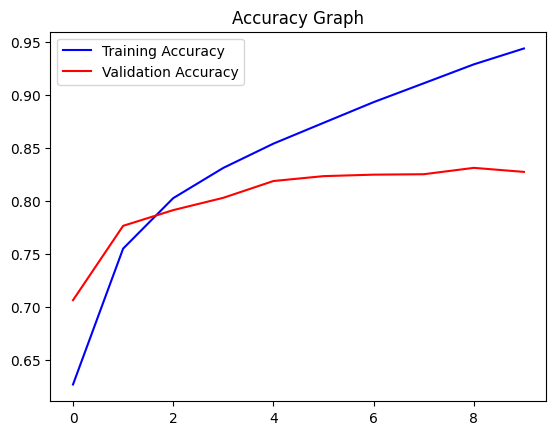

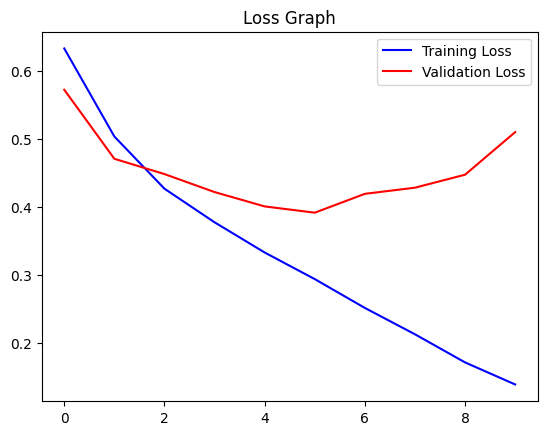

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Test with Real Image

In [51]:
image_path = os.path.abspath("PetImages/Cat/0.jpg")  # Get full path
img = load_img(image_path, target_size=(50, 50))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 50,50, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Cat


In [53]:
# Save the entire model (architecture + weights + optimizer state)
model.save("cats_vs_dogs_model.keras")


In [68]:
from keras.models import load_model
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import os

# Load model
model = load_model("cats_vs_dogs_model.keras")

# Check model input shape
model_input_size = model.input_shape[1:3]  # Get expected (height, width)
print("Model expects image size:", model_input_size)

# Correct image path (Use raw string or double backslashes for Windows)
image_path = r"PetImages\Cat\0.jpg"  # or use: "PetImages/Dog/12480.jpg"
print("Image path:", image_path)

# Check if file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Error: Image file not found at {image_path}")

# Load and preprocess image
img = load_img(image_path, target_size=model_input_size)  # Resize image
img_array = img_to_array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Reshape for model input

# Verify shapes
print("Final Image shape:", img_array.shape)

# Predict
prediction = model.predict(img_array)

# Interpret result
if prediction[0] > 0.5:
    print("Predicted: Dog 🐶")
else:
    print("Predicted: Cat 🐱")


Model expects image size: (50, 50)
Image path: PetImages\Cat\0.jpg
Final Image shape: (1, 50, 50, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Predicted: Cat 🐱
